# HW6 Reinforcement Learning

*   Author: Yuege Xie (EID:yx4256)
*   Python version: Python 3
*   CS 391L Machine Learning HW2

In [0]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1023)
# check the python version
from platform import python_version
print("Current python version is {}".format(python_version()))
%matplotlib inline

Current python version is 3.6.9


In [0]:
def hamming_dis(state1, state2):
    return sum(abs(np.array(state1) -np.array(state2)))

class EnvForward:
    def __init__(self, col , row, goal, seed):
        self.col = col
        self.row = row
        self.states = [(a,b) for a in range(col) for b in range(row)]
        self.actions = [(a,b) for a in range(2) for b in range(2)]
        
        np.random.seed(seed)
        self.init = (0, np.random.choice(row))
        self.end = (col-1, goal)
        self.trace = {'init': self.init,'act':[], 'pos':[]}

    # returns (abstract state, reward)
    def step(self, state, action):
        next_state = tuple(p+q for p, q in zip(state, action))
        reward = self.reward(state, action, next_state)
        self.trace['act'].append(action)
        self.trace['pos'].append(next_state)
        return next_state, reward

    def reward(self, state, action, next_state):
        # reach the goal
        if hamming_dis(next_state, self.end) == 0:
            return 100
        if hamming_dis(next_state, self.end) < hamming_dis(state, self.end): 
            return 5
        else:
            return -5

In [223]:
# test
envf = EnvForward(col=25, row=3, goal=1, seed=1023)
next_step, reward = envf.step(envf.init, (0,1))
next_step, reward = envf.step(next_step, (1,0))
envf.trace

{'act': [(0, 1), (1, 0)], 'init': (0, 0), 'pos': [(0, 1), (1, 1)]}

In [0]:
def plot_results(env):
    
    # plot grid
    fig = plt.figure(figsize=(18,6))
    ax = fig.add_subplot(1, 1, 1)
    plt.xlim(-.5, env.col-0.5)
    plt.ylim(-.5, env.row-0.5)
    y_minor_ticks = np.arange(0, env.row, 1)
    x_minor_ticks = np.arange(0, env.col, 1)
    ax.set_xticks(x_minor_ticks, minor=True)
    ax.set_yticks(y_minor_ticks, minor=True)  
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(which='both')
    
    # plot initial and end points
    plt.plot(env.trace['init'][0], env.trace['init'][1] , 
             's', color='r', markersize=12)
    plt.plot(env.end[0], env.end[1], 'D', color='g', markersize=12)

    # plot trace
    for i in range(len(env.trace['pos'])):
        x, y = env.trace['pos'][i][0], env.trace['pos'][i][1]
        dx, dy = env.trace['act'][i][0], env.trace['act'][i][1]
        plt.plot(x, y, 'o', color='b')
        plt.arrow(x-dx, y-dy, max(dx-0.15, 0), max(dy-0.15, 0), 
                  head_width=0.2, head_length=0.1, fc='k', ec='k')
    plt.show()  

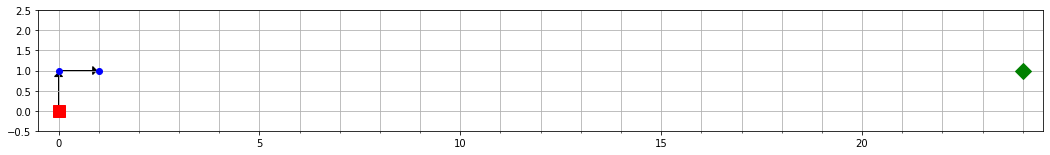

In [294]:
plot_results(envf)

In [0]:
def train(env):
    return policy

# class QPolicy:
#     def __init__(self):
        
#     def act(self, state, env):
#         return action

class EpsilonPolicy:
    def __init__(self, env, eps):
        self.env = env
        self.eps = eps
    def act(self, state):
        if np.random.uniform() > self.eps:
            action = max(actions, key=lambda k: q[k])
        
        else:
            action =  np.random.choice(self.env.actions)
        return action

In [0]:
class QTable:
    def __init__(self, env, lr=0.9, eps=0.9, gamma=0.9):
        self.env = env
        self.lr = lr
        self.eps = eps
        self.gamma = gamma
        self.qtable = {}
        # initiaize q table
        for s in states:
            self.qtable[s] = {}
            for a in actions:    
                self.qtable[s][a] = 0.0
    
    def get_action(self, state):
        if np.random.uniform() < self.eps:
            action = max(actions, key=lambda k: self.qtable[state][k])
        else:
            action =  np.random.choice(self.actions)
        return action

    def update(self, state, action, reward, next_state):

        q_now = self.qtable[state][action]

        if next_state != self.env.end:
            q_next = reward + self.gamma * max(self.qtable[next_state].values())
        else:
            q_next = reward

        self.qtable[state][action] += self.lr * (q_next - q_now)

## "Forth" Module

## "Stay on the Path" Module

## "Obstacles" Module

## "Litter" Module

## Final Module